# BBM444 - Assignment 4: Image Deblurring![U-Net.png](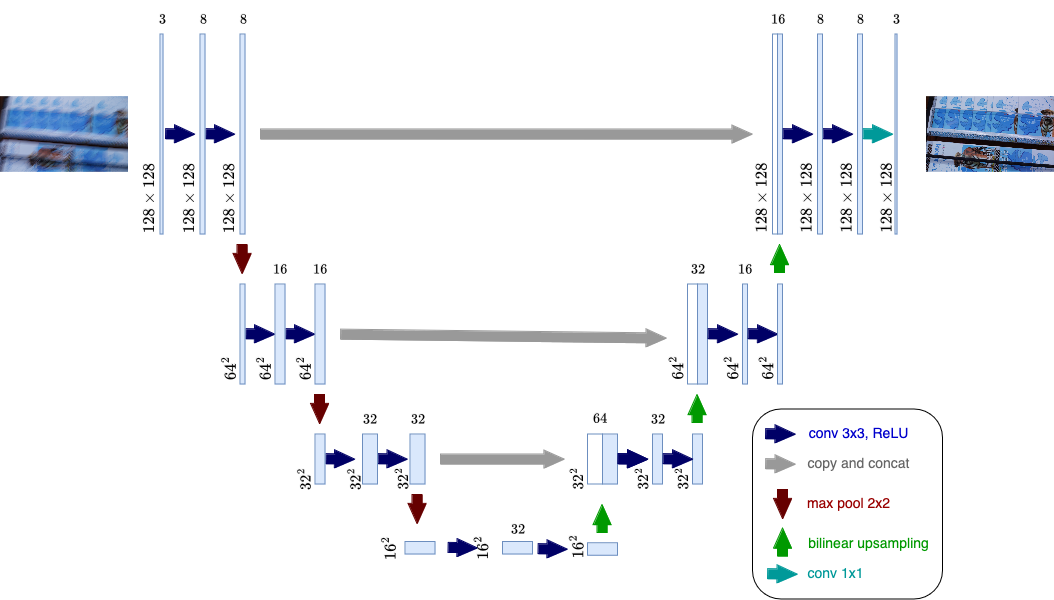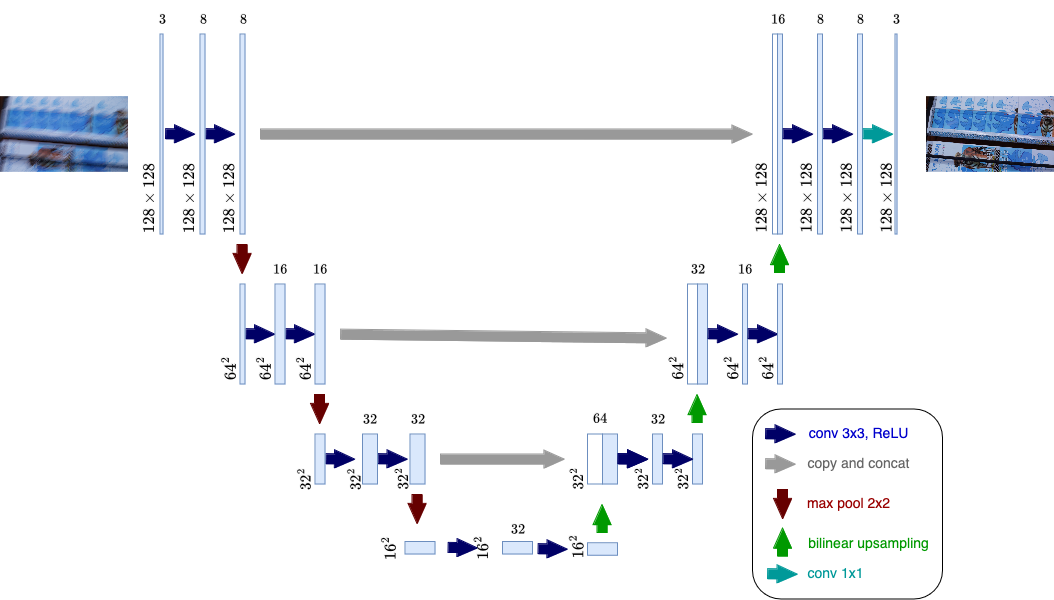)

Bora Dere - 2220765021

## Downloading dataset

You can download the dataset from [link](https://drive.google.com/drive/folders/1XyYsksX99dH3EEdMDHzbo3vqLtIfripN?usp=sharing). Or you can download to the Colab environment by running the cell below. There are two folders in the dataset "train" and "test". The "train" folder includes the images you will use in training. And "test" folder includes images you will use in evaluation only.

In [8]:
# Download the dataset into dataset.zip
# !gdown --id 1hMUJnzXoyJZkj8UN9jbpizFwscjBxN19 -O dataset.zip

In [9]:
# Extract the contents of the file.
# !unzip -q dataset.zip

## Download link for weights:
https://drive.google.com/drive/folders/16gRID4CbGEemoN_Nx3ZO0OhmCGFmjXzs?usp=sharing

## Import Libraries

You can use PyTorch or Tensorflow/Keras(no restrictions).

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import random_split
import torchsummary
from torch.utils.data import DataLoader, TensorDataset
from torch.optim.lr_scheduler import CosineAnnealingLR
from torchmetrics.functional import structural_similarity_index_measure as ssim
from torchmetrics.functional import peak_signal_noise_ratio as psnr

import os
import numpy as np
import random
from PIL import Image
import matplotlib.pyplot as plt

We set a manual seed (42) to Python's random, numpy and torch. And also declare some constants that we use in experiments.

In [ ]:
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

DATA_DIR = os.path.join(os.getcwd(), 'dataset')
TEST_DIR = os.path.join(DATA_DIR, 'test')
TRAIN_DIR = os.path.join(DATA_DIR, 'train')

## Input Preparation

 Develop the RAW into sRGB TIFF format using dcraw command

Since the images created by 2 different dcraw commands will have the same name, thus causing a name collision, I updated the commands a bit. For inputs:

In [12]:
# Get-ChildItem *.dng | ForEach-Object {
#     $base = $_.BaseName
#     dcraw -w -q 3 -o 1 -6 -g 1 1 -T -O "$base`_srgb.tiff" "$($_.Name)"
# }

And for labels:

In [13]:
# Get-ChildItem *.dng | ForEach-Object {
#     $base = $_.BaseName
#     dcraw -4 -D -T -O "$base`_raw.tiff" "$($_.Name)"
# }

**Load the dataset**

In the cell below, we load sRGB and RAW images.

In [ ]:
def prepare_inputs(dir_path):
    """
    Function to prepare input images for training.

    :param dir_path: Directory path containing the images.

    :return: A tuple containing a tensor of images and a list of filenames.
    """
    tensors = []
    filenames = []
    flag = True

    for fname in os.listdir(dir_path):
        if not fname.endswith('_srgb.tiff'):
            continue

        img = Image.open(os.path.join(dir_path, fname))
        base_filename = fname.replace('_srgb.tiff', '')
        filenames.append(base_filename)
        img_np = np.array(img).astype(np.float64) / 65535.0 

        H, W, C = img_np.shape

        Nx = max(1, H // 256)
        Ny = max(1, W // 256)
        ds = img_np[::Nx, ::Ny, :] 

        h2, w2, _ = ds.shape
        top  = (h2 - 256) // 2
        left = (w2 - 256) // 2
        crop = ds[top:top+256, left:left+256, :]

        sigma = np.random.uniform(0.00005, 0.00009) # updated noise level because it was too high
        noise = np.random.normal(0.0, sigma, size=crop.shape)
        noisy = np.clip(crop + noise, 0.0, 1.0)

        if flag:
            fig, axes = plt.subplots(1, 2, figsize=(10, 5))
            axes[0].imshow(crop * 255.0)
            axes[0].set_title('Original')

            axes[1].imshow(noisy * 255.0)
            axes[1].set_title('Noisy')
            plt.show()
            flag = False

        tensor = torch.from_numpy(noisy.transpose(2, 0, 1)).to(torch.float64)
        tensors.append(tensor)

    return torch.stack(tensors, dim=0), filenames

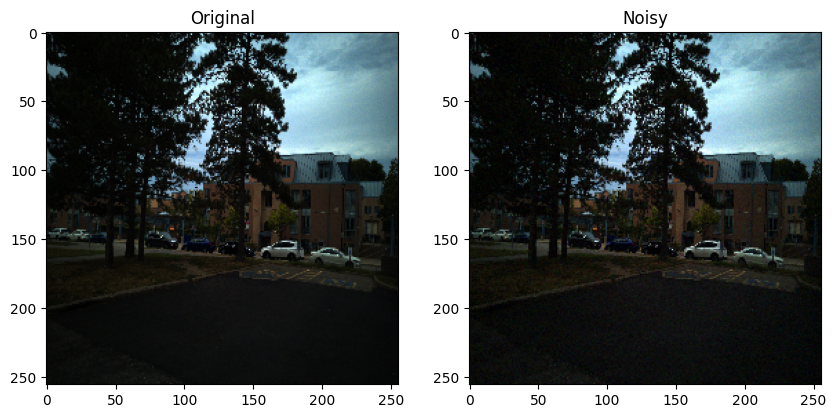

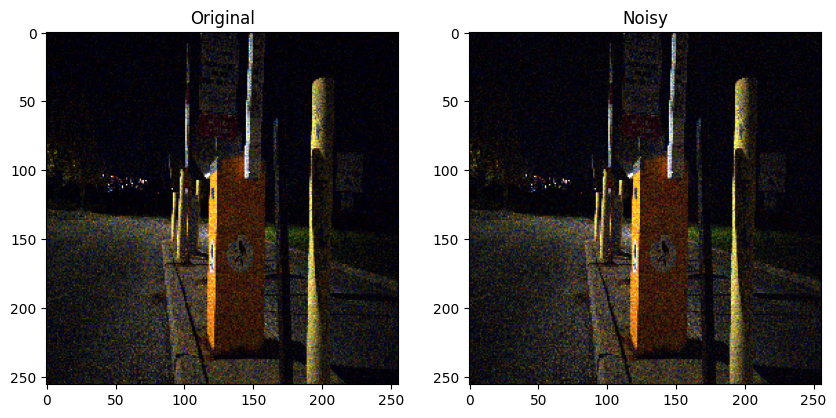

In [15]:
X_train, train_filenames = prepare_inputs(TRAIN_DIR)
X_test, test_filenames = prepare_inputs(TEST_DIR)

In [ ]:
def prepare_labels(dir_path, input_filenames):
    """
    Function to prepare labels from the raw images.

    :param dir_path: Directory path containing the images.
    :param input_filenames: List of filenames to process.

    :return: A tensor of labels.
    """
    black, white = 64, 1023
    packed_list = []

    for base_filename in input_filenames:
        raw_filename = f"{base_filename}_raw.tiff"
        
        img = Image.open(os.path.join(dir_path, raw_filename))
        raw = np.array(img).astype(np.float64)

        raw = (raw - black) / (white - black)
        np.clip(raw, 0, 1, out=raw)

        G1 = raw[0::2, 1::2] 
        R  = raw[0::2, 0::2] 
        G2 = raw[1::2, 0::2] 
        B  = raw[1::2, 1::2] 

        packed = np.stack([G1, R, G2, B], axis=0)  

        _, H, W = packed.shape
        Nx = max(1, H // 128)
        Ny = max(1, W // 128)
        packed_ds = packed[:, ::Nx, ::Ny]

        _, h2, w2 = packed_ds.shape
        top  = (h2 - 128) // 2
        left = (w2 - 128) // 2
        cropped = packed_ds[:, top:top+128, left:left+128]

        packed_tensor = torch.from_numpy(cropped).to(torch.float64)
        packed_list.append(packed_tensor)

    return torch.stack(packed_list, dim=0)

In [17]:
y_train = prepare_labels(TRAIN_DIR, train_filenames)
y_test = prepare_labels(TEST_DIR, test_filenames)

In [18]:
# Split the dataset into train and test
# what? it's already split?



#######################
print(f"Shape of train samples: {X_train[0].shape}")
print(f"Shape of ground-truth image: {y_train[0].shape}")
print(f"{len(X_train)} samples in train\n{len(X_test)} samples in test")

Shape of train samples: torch.Size([3, 256, 256])
Shape of ground-truth image: torch.Size([4, 128, 128])
130 samples in train
45 samples in test


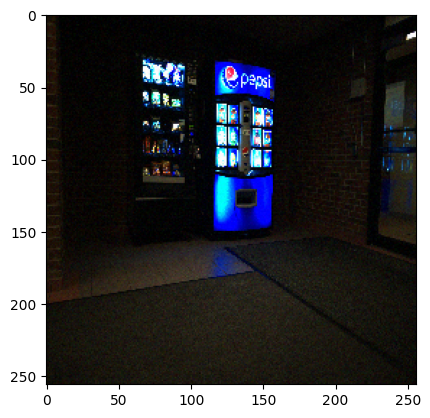

In [19]:
# Display a random image from the dataset
plt.imshow(X_train[42].permute(1, 2, 0).numpy() * 255.0)

**Downsampling**

In [20]:
# order of run in this notebook is a bit odd to me, that's why these cells are empty and the image above is kinda redundant

**Noise augmentation**

In [21]:
# :)

## Label Preparation

## Data Split

Merge the inputs and labels to create the dataset. Then, split them into patches into 90 % train, 10 % validation

In [ ]:
# train statistics
mean = X_train.mean(dim=(0, 2, 3))
std  = X_train.std(dim=(0, 2, 3))

print(f"Mean of the train set is: {mean}")
print(f"Standard deviation of the train set is: {std}")

def normalize_tensor_batch(batch, mean, std):
    return (batch - mean.view(3, 1, 1)) / std.view(3, 1, 1)

X_train_norm = normalize_tensor_batch(X_train, mean, std)
X_test_norm  = normalize_tensor_batch(X_test, mean, std)

num_total = X_train_norm.shape[0]
num_val = int(0.1 * num_total)
num_train = num_total - num_val

X_train_split, X_val = random_split(X_train_norm, [num_train, num_val], generator=torch.Generator().manual_seed(42))
y_train_split, y_val = random_split(y_train, [num_train, num_val], generator=torch.Generator().manual_seed(42))

train_indices = X_train_split.indices
val_indices = X_val.indices

X_train_final = X_train_norm[train_indices]
y_train_final = y_train[train_indices]

X_val_final = X_train_norm[val_indices]
y_val_final = y_train[val_indices]

Mean of the train set is: tensor([0.0008, 0.0008, 0.0007], dtype=torch.float64)
Standard deviation of the train set is: tensor([0.0008, 0.0008, 0.0008], dtype=torch.float64)


# **Model Architecture & Training**

## Stage I: sRGB → 4-Plane RAW

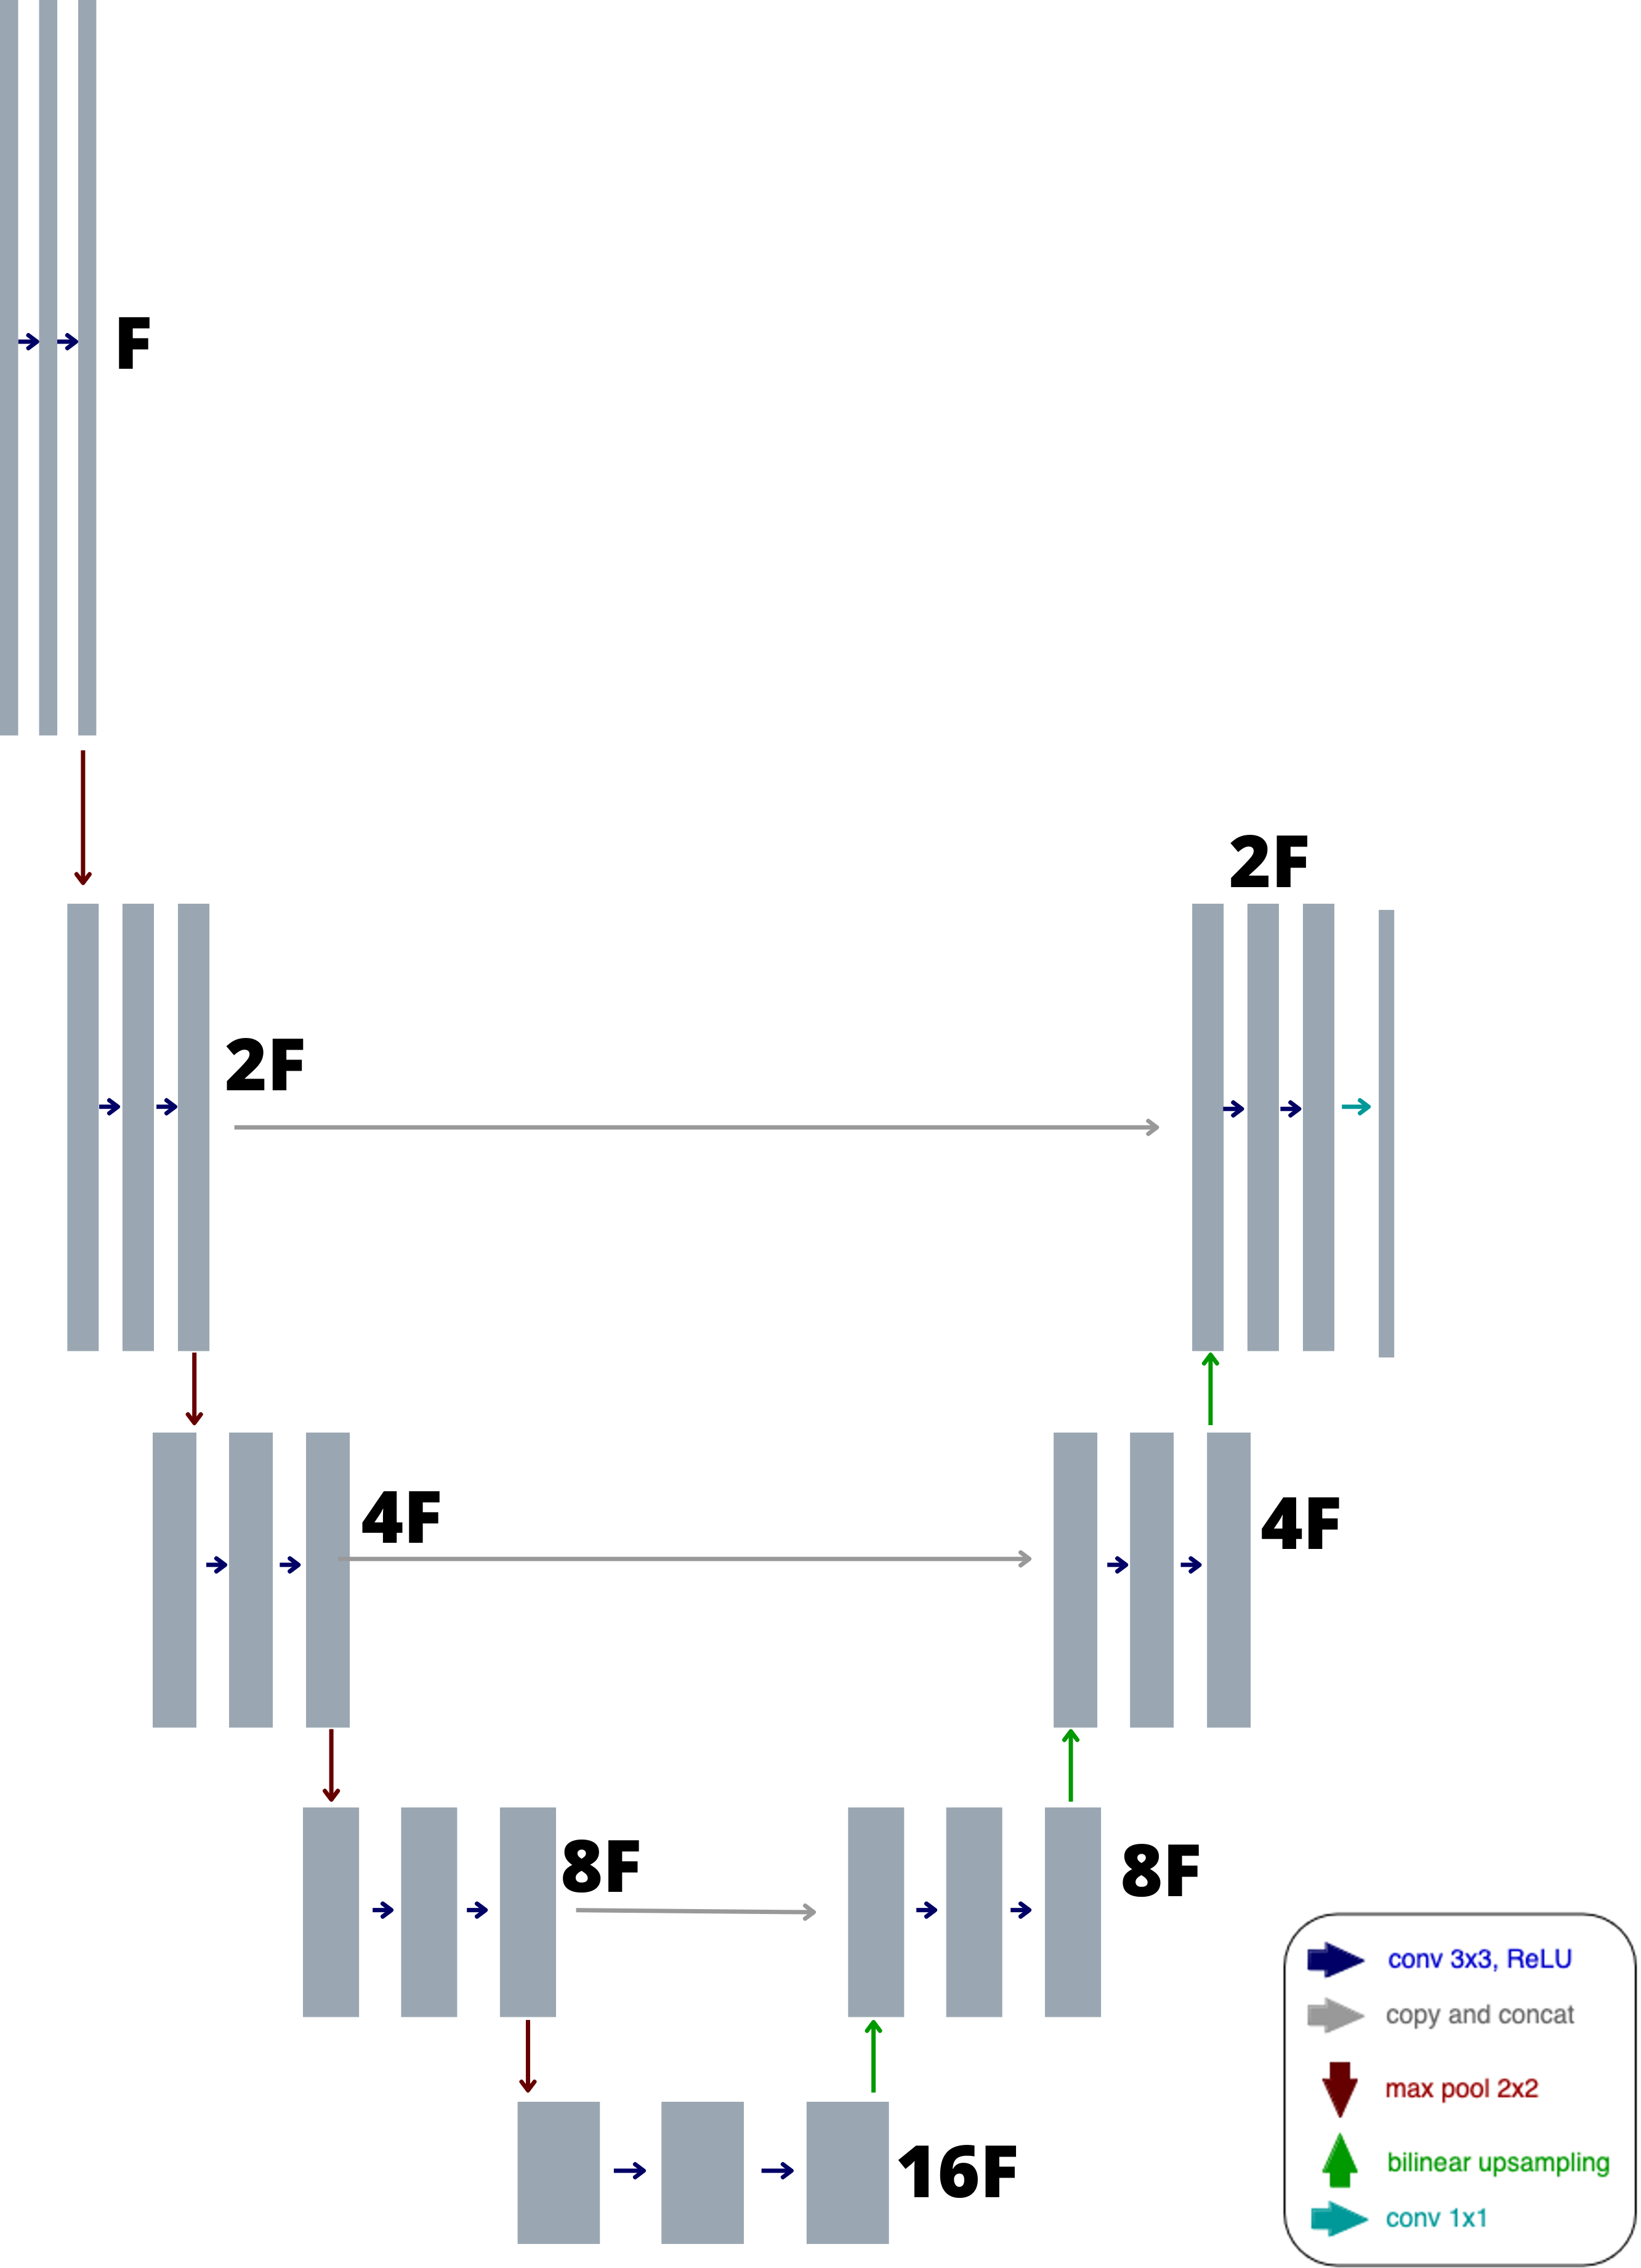

**Note:** The cells below are designed to guide you to build the your modified UNET. But you are not required to follow the structure below.

In [ ]:
class DoubleConv(nn.Module):
    """(Conv3x3 + ReLU) x 2"""
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.block(x)

class UNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=4, base_filters=8):
        super().__init__()
        F = base_filters

        # Encoder
        self.enc1 = DoubleConv(in_channels, F)
        self.pool1 = nn.MaxPool2d(2)

        self.enc2 = DoubleConv(F, 2*F)
        self.pool2 = nn.MaxPool2d(2)

        self.enc3 = DoubleConv(2*F, 4*F)
        self.pool3 = nn.MaxPool2d(2)

        self.enc4 = DoubleConv(4*F, 8*F)
        self.pool4 = nn.MaxPool2d(2)

        # Bottleneck
        self.bottleneck = DoubleConv(8*F, 16*F)

        # Decoder
        self.up3 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.dec3 = DoubleConv(16*F + 8*F, 8*F)

        self.up2 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.dec2 = DoubleConv(8*F + 4*F, 4*F)

        self.up1 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.dec1 = DoubleConv(4*F + 2*F, 2*F)

        self.final_conv = nn.Conv2d(2*F, out_channels, kernel_size=1)

    def forward(self, x):
        # Encoder
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool1(e1))
        e3 = self.enc3(self.pool2(e2))
        e4 = self.enc4(self.pool3(e3))

        # Bottleneck
        b = self.bottleneck(self.pool4(e4))

        # Decoder
        d3 = self.up3(b)
        d3 = torch.cat([d3, e4], dim=1)
        d3 = self.dec3(d3)

        d2 = self.up2(d3)
        d2 = torch.cat([d2, e3], dim=1)
        d2 = self.dec2(d2)

        d1 = self.up1(d2)
        d1 = torch.cat([d1, e2], dim=1)
        d1 = self.dec1(d1)

        return self.final_conv(d1)

In [24]:
unet = UNet()

input_size= (3, 256, 256)
torchsummary.summary(unet.cuda(), input_size=input_size)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 8, 256, 256]             224
              ReLU-2          [-1, 8, 256, 256]               0
            Conv2d-3          [-1, 8, 256, 256]             584
              ReLU-4          [-1, 8, 256, 256]               0
        DoubleConv-5          [-1, 8, 256, 256]               0
         MaxPool2d-6          [-1, 8, 128, 128]               0
            Conv2d-7         [-1, 16, 128, 128]           1,168
              ReLU-8         [-1, 16, 128, 128]               0
            Conv2d-9         [-1, 16, 128, 128]           2,320
             ReLU-10         [-1, 16, 128, 128]               0
       DoubleConv-11         [-1, 16, 128, 128]               0
        MaxPool2d-12           [-1, 16, 64, 64]               0
           Conv2d-13           [-1, 32, 64, 64]           4,640
             ReLU-14           [-1, 32,

### Train the network

In [25]:
batch_size = 8
epochs = 50
lr = 1e-4
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [26]:
train_dataset = TensorDataset(X_train_final, y_train_final)
val_dataset   = TensorDataset(X_val_final, y_val_final)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=batch_size)

model = UNet(in_channels=3, out_channels=4).to(device).double()
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = CosineAnnealingLR(optimizer, T_max=epochs)

In [27]:
best_val_loss = float('inf')

for epoch in range(1, epochs + 1):
    model.train()
    running_loss = 0.0

    for x, y in train_loader:
        x, y = x.to(device), y.to(device)

        if torch.rand(1) < 0.5:
            x = torch.flip(x, dims=[-1])  
            y = torch.flip(y, dims=[-1])
        if torch.rand(1) < 0.5:
            x = torch.flip(x, dims=[-2])  
            y = torch.flip(y, dims=[-2])
        if torch.rand(1) < 0.5:
            k = torch.randint(1, 4, (1,)).item()
            x = torch.rot90(x, k, dims=[-2, -1])
            y = torch.rot90(y, k, dims=[-2, -1])
        if torch.rand(1) < 0.5:
            exposure = torch.rand(1).item() * 0.6 - 0.3
            x = torch.clamp(x * (2 ** exposure), 0, 1)

        optimizer.zero_grad()
        pred1 = model(x)

        l1_loss = nn.functional.l1_loss(pred1, y)
        ssim_loss = 1 - ssim(pred1, y, data_range=1.0)
        loss = 0.8 * l1_loss + 0.2 * ssim_loss

        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for x, y in val_loader:
            x, y = x.to(device), y.to(device)
            pred1 = model(x)
            l1 = nn.functional.l1_loss(pred1, y)
            ssim_val = 1 - ssim(pred1, y, data_range=1.0)
            loss = 0.8 * l1 + 0.2 * ssim_val
            val_loss += loss.item()

    val_loss /= len(val_loader)
    print(f"Epoch {epoch:02d} | Train Loss: {running_loss/len(train_loader):.4f} | Val Loss: {val_loss:.4f}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'best_model_stage1.pth')

    scheduler.step()

/usr/local/lib/python3.11/dist-packages/torchmetrics/utilities/prints.py:70: FutureWarning: Importing `spectral_angle_mapper` from `torchmetrics.functional` was deprecated and will be removed in 2.0. Import `spectral_angle_mapper` from `torchmetrics.image` instead.
  _future_warning(


Epoch 01 | Train Loss: 0.2379 | Val Loss: 0.2337
Epoch 02 | Train Loss: 0.2322 | Val Loss: 0.2276
Epoch 03 | Train Loss: 0.2246 | Val Loss: 0.2152
Epoch 04 | Train Loss: 0.2064 | Val Loss: 0.1977
Epoch 05 | Train Loss: 0.1654 | Val Loss: 0.1447
Epoch 06 | Train Loss: 0.1439 | Val Loss: 0.1395
Epoch 07 | Train Loss: 0.1413 | Val Loss: 0.1377
Epoch 08 | Train Loss: 0.1381 | Val Loss: 0.1321
Epoch 09 | Train Loss: 0.1341 | Val Loss: 0.1268
Epoch 10 | Train Loss: 0.1277 | Val Loss: 0.1205
Epoch 11 | Train Loss: 0.1222 | Val Loss: 0.1148
Epoch 12 | Train Loss: 0.1166 | Val Loss: 0.1130
Epoch 13 | Train Loss: 0.1143 | Val Loss: 0.1091
Epoch 14 | Train Loss: 0.1114 | Val Loss: 0.1068
Epoch 15 | Train Loss: 0.1083 | Val Loss: 0.1047
Epoch 16 | Train Loss: 0.1059 | Val Loss: 0.1019
Epoch 17 | Train Loss: 0.1054 | Val Loss: 0.1016
Epoch 18 | Train Loss: 0.1044 | Val Loss: 0.1014
Epoch 19 | Train Loss: 0.1060 | Val Loss: 0.1020
Epoch 20 | Train Loss: 0.1023 | Val Loss: 0.1010
Epoch 21 | Train Los

### Testing

/tmp/ipykernel_31/1740367610.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model_stage1.pth'))


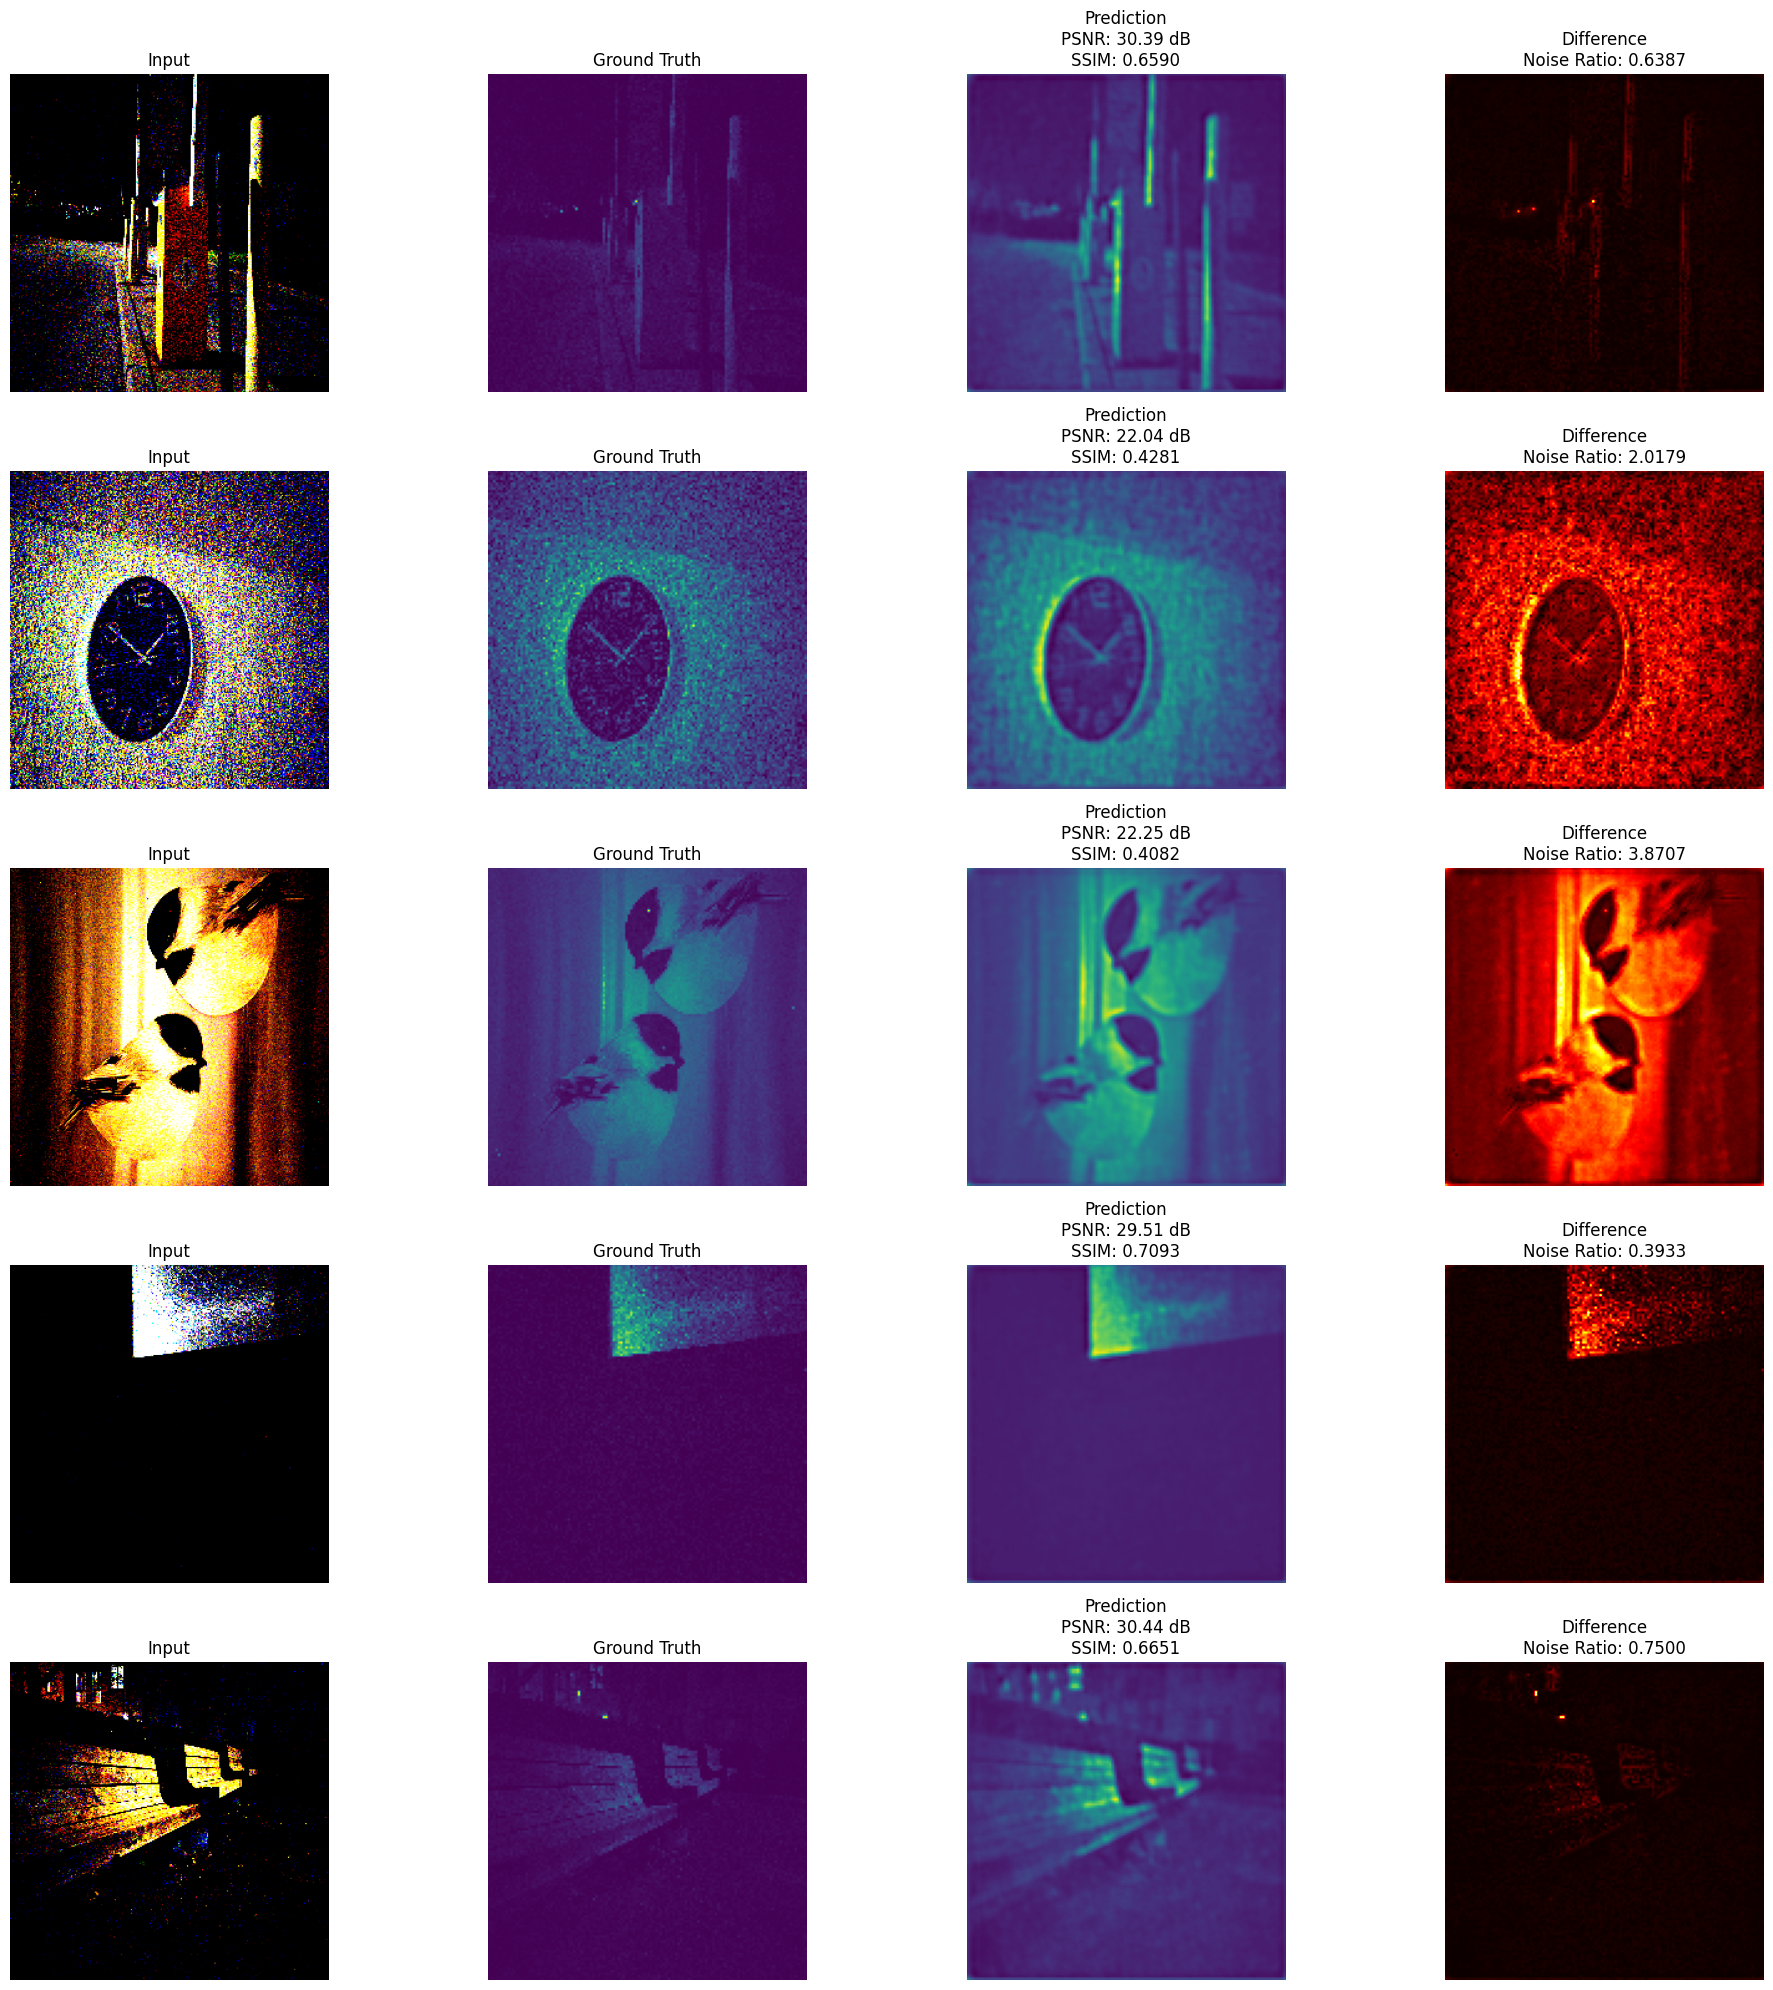


Test Results:
  PSNR          : 25.68 dB
  SSIM          : 0.5390
  Noise Ratio   : 1.7966


In [ ]:
model.load_state_dict(torch.load('best_model_stage1.pth'))
model.eval()

psnr_total = 0.0
ssim_total = 0.0
noise_ratio_total = 0.0

X_test_norm = X_test_norm.to(device)
y_test = y_test.to(device)

indices = list(range(5)) 

plt.figure(figsize=(20, 20))

with torch.no_grad():
    for i in range(X_test_norm.shape[0]):
        x = X_test_norm[i].unsqueeze(0).to(device)  
        y = y_test[i].unsqueeze(0).to(device)       

        pred = model(x)

        psnr_val = psnr(pred, y, data_range=1.0)
        psnr_total += psnr_val.item()

        ssim_val = ssim(pred, y, data_range=1.0)
        ssim_total += ssim_val.item()

        diff = torch.norm(pred - y)
        ref = torch.norm(y)
        noise_ratio = diff / ref
        noise_ratio_total += noise_ratio.item()

        if i in indices:
            idx_in_vis = indices.index(i)
            
            input_img = x.squeeze().cpu().permute(1, 2, 0).numpy()
            
            gt_img = y.squeeze().cpu()[0].numpy()  
            pred_img = pred.squeeze().cpu()[0].numpy()  
            diff_img = np.abs(gt_img - pred_img)
            
            # if needed
            input_img = np.clip(input_img, 0, 1)
            
            plt.subplot(5, 4, idx_in_vis*4+1)
            plt.imshow(input_img)
            plt.title(f"Input")
            plt.axis('off')
            
            plt.subplot(5, 4, idx_in_vis*4+2)
            plt.imshow(gt_img, cmap='viridis')
            plt.title(f"Ground Truth")
            plt.axis('off')
            
            plt.subplot(5, 4, idx_in_vis*4+3)
            plt.imshow(pred_img, cmap='viridis')
            plt.title(f"Prediction\nPSNR: {psnr_val.item():.2f} dB\nSSIM: {ssim_val.item():.4f}")
            plt.axis('off')
            
            plt.subplot(5, 4, idx_in_vis*4+4)
            plt.imshow(diff_img, cmap='hot')
            plt.title(f"Difference\nNoise Ratio: {noise_ratio.item():.4f}")
            plt.axis('off')

n = X_test_norm.shape[0]
avg_psnr = psnr_total / n
avg_ssim = ssim_total / n
avg_noise_ratio = noise_ratio_total / n

plt.tight_layout()
plt.show()

print(f"\nTest Results:")
print(f"  PSNR          : {avg_psnr:.2f} dB")
print(f"  SSIM          : {avg_ssim:.4f}")
print(f"  Noise Ratio   : {avg_noise_ratio:.4f}")

###  Stage II: sRGB → Single-Channel Full-Res Bayer

In [ ]:
def prepare_bayer_labels(dir_path, input_filenames):
    """
    Function to prepare Bayer labels from raw images.

    :param dir_path: Directory path containing the images.
    :param input_filenames: List of filenames to process.

    :return: A tensor of Bayer labels.
    """
    black, white = 64, 1023
    bayer_list = []
    for base_filename in input_filenames:
        raw_filename = f"{base_filename}_raw.tiff"
        
        img = Image.open(os.path.join(dir_path, raw_filename))
        raw = np.array(img).astype(np.float64)

        raw = (raw - black) / (white - black)
        np.clip(raw, 0, 1, out=raw)
        
        H, W = raw.shape
        Nx = max(1, H // 256)
        Ny = max(1, W // 256)
        raw_ds = raw[::Nx, ::Ny]

        h2, w2 = raw_ds.shape
        top = (h2 - 256) // 2
        left = (w2 - 256) // 2
        cropped = raw_ds[top:top+256, left:left+256]
        
        tensor = torch.from_numpy(cropped).unsqueeze(0).to(torch.float64)
        bayer_list.append(tensor)

    return torch.stack(bayer_list, dim=0)

y_train_bayer = prepare_bayer_labels(TRAIN_DIR, train_filenames)
y_test_bayer = prepare_bayer_labels(TEST_DIR, test_filenames)

train_indices = X_train_split.indices
val_indices = X_val.indices

X_train_final_s2 = X_train_norm[train_indices]
y_train_final_s2 = y_train_bayer[train_indices]

X_val_final_s2 = X_train_norm[val_indices]
y_val_final_s2 = y_train_bayer[val_indices]

train_dataset_s2 = TensorDataset(X_train_final_s2, y_train_final_s2)
val_dataset_s2 = TensorDataset(X_val_final_s2, y_val_final_s2)

train_loader_s2 = DataLoader(train_dataset_s2, batch_size=batch_size, shuffle=True)
val_loader_s2 = DataLoader(val_dataset_s2, batch_size=batch_size)

### Update the Labels, so the dataset

### Update the model

In [ ]:
class UNetStage2(nn.Module):
    def __init__(self, in_channels=3, out_channels=1, base_filters=8):
        super().__init__()
        F = base_filters
        
        # Encoder 
        self.enc1 = DoubleConv(in_channels, F)
        self.pool1 = nn.MaxPool2d(2)

        self.enc2 = DoubleConv(F, 2*F)
        self.pool2 = nn.MaxPool2d(2)

        self.enc3 = DoubleConv(2*F, 4*F)
        self.pool3 = nn.MaxPool2d(2)

        self.enc4 = DoubleConv(4*F, 8*F)
        self.pool4 = nn.MaxPool2d(2)

        # Bottleneck 
        self.bottleneck = DoubleConv(8*F, 16*F)

        # Decoder 
        self.up3 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.dec3 = DoubleConv(16*F + 8*F, 8*F)

        self.up2 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.dec2 = DoubleConv(8*F + 4*F, 4*F)

        self.up1 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.dec1 = DoubleConv(4*F + 2*F, 2*F)

        # additional upsampling block for Stage 2
        self.up0 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.dec0 = DoubleConv(2*F + F, F)
        
        self.final_conv = nn.Conv2d(F, out_channels, kernel_size=1)

    def forward(self, x):
        # Encoder
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool1(e1))
        e3 = self.enc3(self.pool2(e2))
        e4 = self.enc4(self.pool3(e3))

        # Bottleneck
        b = self.bottleneck(self.pool4(e4))

        # Decoder
        d3 = self.up3(b)
        d3 = torch.cat([d3, e4], dim=1)
        d3 = self.dec3(d3)

        d2 = self.up2(d3)
        d2 = torch.cat([d2, e3], dim=1)
        d2 = self.dec2(d2)

        d1 = self.up1(d2)
        d1 = torch.cat([d1, e2], dim=1)
        d1 = self.dec1(d1)
        
        d0 = self.up0(d1)
        d0 = torch.cat([d0, e1], dim=1)
        d0 = self.dec0(d0)
    
        return self.final_conv(d0)

In [ ]:
def transfer_weights_stage1_to_stage2(model_s1, model_s2):
    """Transfer compatible weights from Stage 1 model to Stage 2"""
    s1_state_dict = model_s1.state_dict()
    s2_state_dict = model_s2.state_dict()
    
    for name, param in s1_state_dict.items():
        if name in s2_state_dict and s2_state_dict[name].shape == param.shape:
            s2_state_dict[name].copy_(param)
    
    return model_s2

model_s1 = UNet(in_channels=3, out_channels=4).to(device).double()
model_s1.load_state_dict(torch.load('best_model_stage1.pth'))

model_s2 = UNetStage2(in_channels=3, out_channels=1).to(device).double()
model_s2 = transfer_weights_stage1_to_stage2(model_s1, model_s2)

/tmp/ipykernel_31/3106051616.py:16: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_s1.load_state_dict(torch.load('best_model_stage1.pth'))


### Train the network

In [ ]:
optimizer_s2 = optim.Adam(model_s2.parameters(), lr=lr)
scheduler_s2 = CosineAnnealingLR(optimizer_s2, T_max=epochs)

best_val_loss_s2 = float('inf')

for epoch in range(1, epochs + 1):
    model_s2.train()
    running_loss = 0.0
    
    for x, mosaic in train_loader_s2:
        x, mosaic = x.to(device), mosaic.to(device)

        if torch.rand(1) < 0.5:
            x = torch.flip(x, dims=[-1])  
            mosaic = torch.flip(mosaic, dims=[-1])
        if torch.rand(1) < 0.5:
            x = torch.flip(x, dims=[-2])  
            mosaic = torch.flip(mosaic, dims=[-2])
        if torch.rand(1) < 0.5:
            k = torch.randint(1, 4, (1,)).item()
            x = torch.rot90(x, k, dims=[-2, -1])
            mosaic = torch.rot90(mosaic, k, dims=[-2, -1])
        if torch.rand(1) < 0.5:
            exposure = torch.rand(1).item() * 0.6 - 0.3
            x = torch.clamp(x * (2 ** exposure), 0, 1)

        optimizer_s2.zero_grad()
        pred2 = model_s2(x)

        l1_loss = nn.functional.l1_loss(pred2, mosaic)
        ssim_loss = 1 - ssim(pred2, mosaic, data_range=1.0)
        loss = 0.8 * l1_loss + 0.2 * ssim_loss

        loss.backward()
        optimizer_s2.step()

        running_loss += loss.item()
    
    model_s2.eval()
    val_loss = 0.0
    
    with torch.no_grad():
        for x, mosaic in val_loader_s2:
            x, mosaic = x.to(device), mosaic.to(device)
            pred2 = model_s2(x)
            
            # Calculate losses
            l1 = nn.functional.l1_loss(pred2, mosaic)
            ssim_val = 1 - ssim(pred2, mosaic, data_range=1.0)
            loss = 0.8 * l1 + 0.2 * ssim_val
            val_loss += loss.item()
            
    val_loss /= len(val_loader_s2)
    
    print(f"Epoch {epoch:02d} | Train Loss: {running_loss/len(train_loader_s2):.4f} | "
          f"Val Loss: {val_loss:.4f}")

    if val_loss < best_val_loss_s2:
        best_val_loss_s2 = val_loss
        torch.save(model_s2.state_dict(), 'best_model_stage2.pth')

    scheduler_s2.step()

Epoch 01 | Train Loss: 0.1940 | Val Loss: 0.1488
Epoch 02 | Train Loss: 0.1431 | Val Loss: 0.1415
Epoch 03 | Train Loss: 0.1401 | Val Loss: 0.1402
Epoch 04 | Train Loss: 0.1370 | Val Loss: 0.1400
Epoch 05 | Train Loss: 0.1351 | Val Loss: 0.1400
Epoch 06 | Train Loss: 0.1338 | Val Loss: 0.1389
Epoch 07 | Train Loss: 0.1334 | Val Loss: 0.1374
Epoch 08 | Train Loss: 0.1358 | Val Loss: 0.1360
Epoch 09 | Train Loss: 0.1347 | Val Loss: 0.1364
Epoch 10 | Train Loss: 0.1304 | Val Loss: 0.1340
Epoch 11 | Train Loss: 0.1302 | Val Loss: 0.1339
Epoch 12 | Train Loss: 0.1300 | Val Loss: 0.1398
Epoch 13 | Train Loss: 0.1315 | Val Loss: 0.1324
Epoch 14 | Train Loss: 0.1306 | Val Loss: 0.1325
Epoch 15 | Train Loss: 0.1302 | Val Loss: 0.1316
Epoch 16 | Train Loss: 0.1287 | Val Loss: 0.1322
Epoch 17 | Train Loss: 0.1253 | Val Loss: 0.1304
Epoch 18 | Train Loss: 0.1283 | Val Loss: 0.1290
Epoch 19 | Train Loss: 0.1258 | Val Loss: 0.1295
Epoch 20 | Train Loss: 0.1272 | Val Loss: 0.1287
Epoch 21 | Train Los

### Testing

In [ ]:
model_s2 = UNetStage2(in_channels=3, out_channels=1).to(device).double()
model_s2.load_state_dict(torch.load('best_model_stage2.pth'))
model_s2.eval()

psnr_total = 0.0
ssim_total = 0.0
noise_ratio_total = 0.0

predicted_mosaics = []
ground_truth_mosaics = []
input_images = []

X_test_s2 = X_test_norm.to(device)
y_test_s2 = y_test_bayer.to(device)

with torch.no_grad():
    for i in range(X_test_s2.shape[0]):
        x = X_test_s2[i].unsqueeze(0).to(device)  
        y = y_test_s2[i].unsqueeze(0).to(device)  

        pred2 = model_s2(x)
        
        predicted_mosaics.append(pred2.cpu())
        ground_truth_mosaics.append(y.cpu())
        input_images.append(x.cpu())

        psnr_val = psnr(pred2, y, data_range=1.0)
        psnr_total += psnr_val.item()

        ssim_val = ssim(pred2, y, data_range=1.0)
        ssim_total += ssim_val.item()

        diff = torch.norm(pred2 - y)
        ref = torch.norm(y)
        noise_ratio = diff / ref
        noise_ratio_total += noise_ratio.item()

n = X_test_s2.shape[0]
avg_psnr = psnr_total / n
avg_ssim = ssim_total / n
avg_noise_ratio = noise_ratio_total / n

print(f"\nStage 2 Test Results:")
print(f"  PSNR          : {avg_psnr:.2f} dB")
print(f"  SSIM          : {avg_ssim:.4f}")
print(f"  Noise Ratio   : {avg_noise_ratio:.4f}")

# for visualization
predicted_mosaics = torch.cat(predicted_mosaics, dim=0)
ground_truth_mosaics = torch.cat(ground_truth_mosaics, dim=0)
input_images = torch.cat(input_images, dim=0)

/tmp/ipykernel_31/3916110014.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_s2.load_state_dict(torch.load('best_model_stage2.pth'))



Stage 2 Test Results:
  PSNR          : 25.81 dB
  SSIM          : 0.4960
  Noise Ratio   : 1.7070


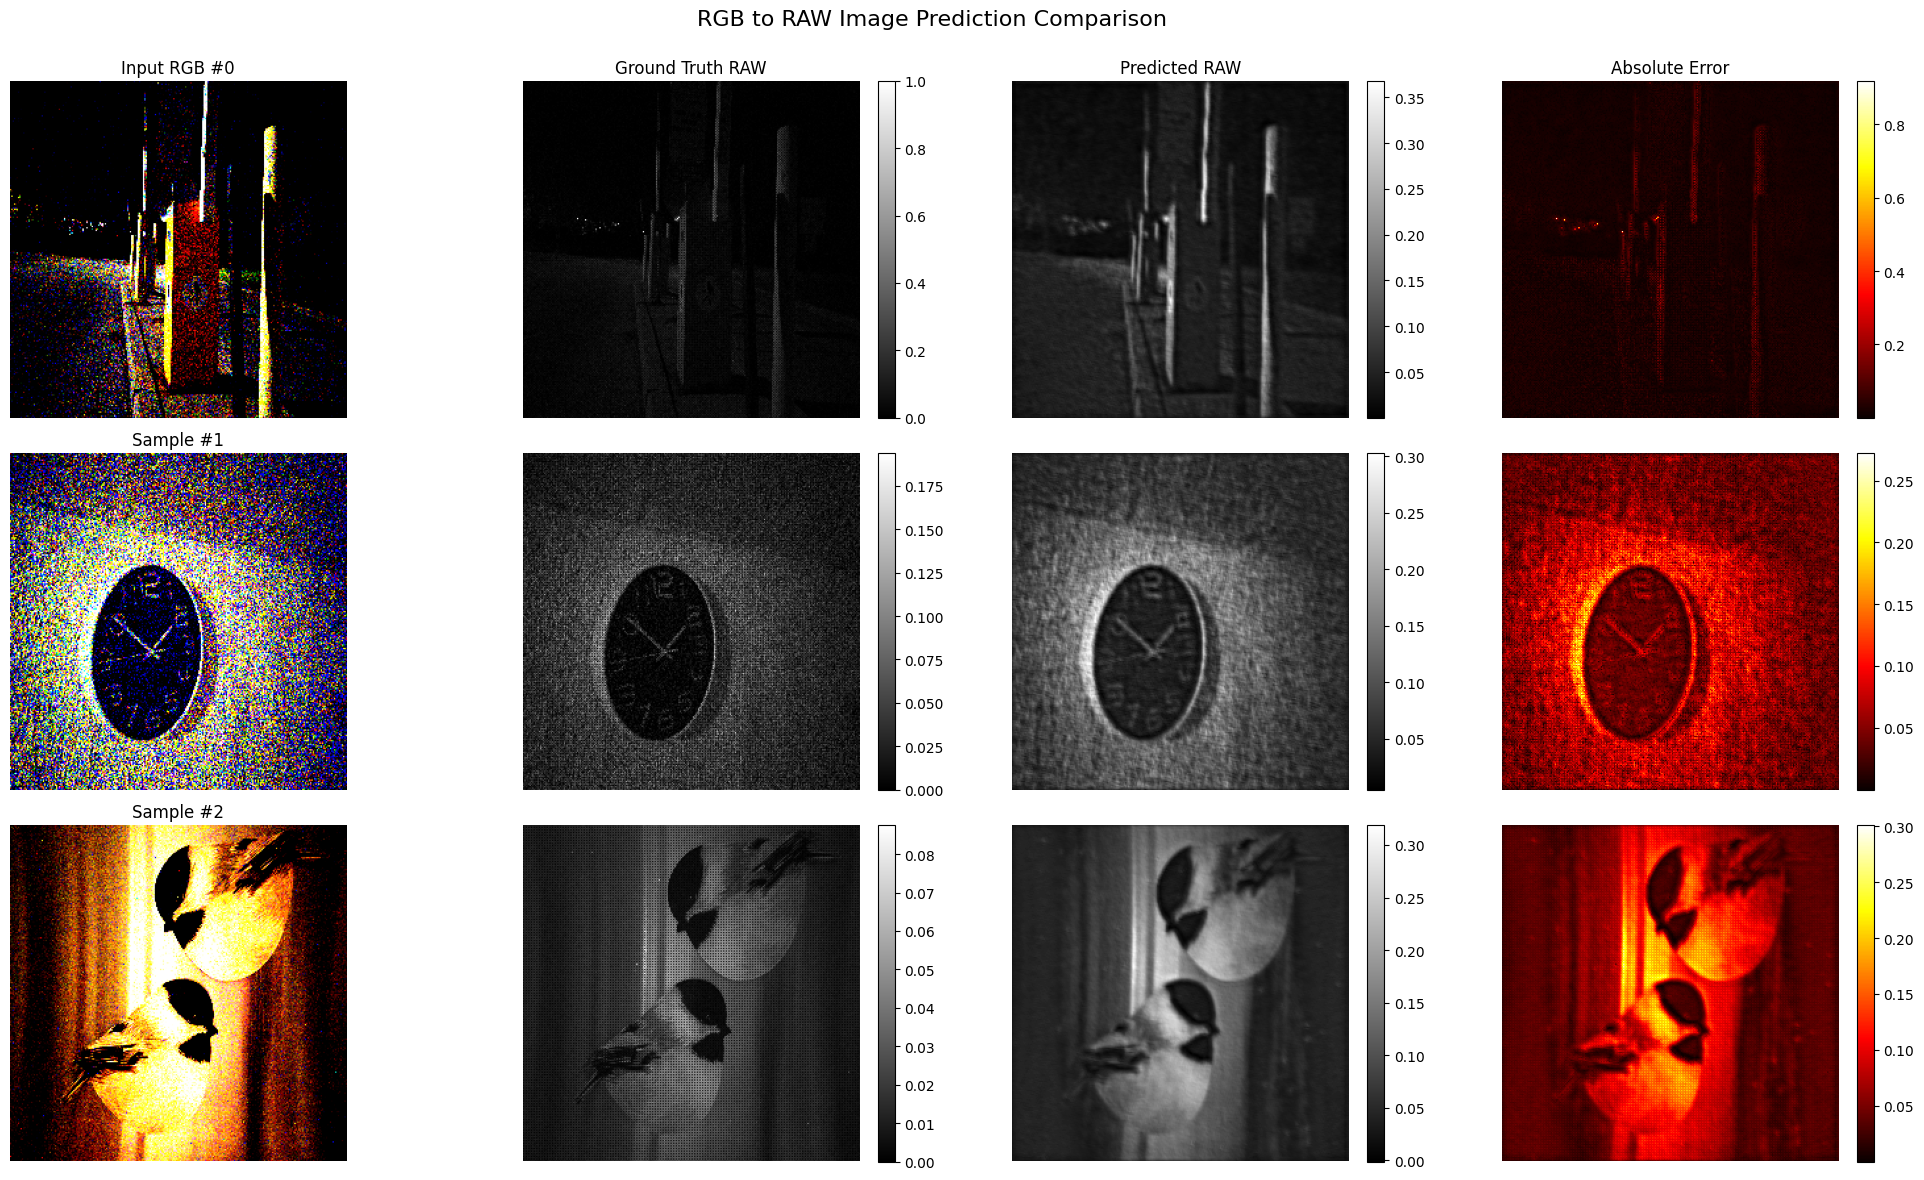

In [ ]:
indices = [0, 1, 2]  
fig, axes = plt.subplots(len(indices), 4, figsize=(20, 12))  

for row, idx in enumerate(indices):
    input_rgb = input_images[idx].permute(1, 2, 0).numpy()  
    
    gt_raw = ground_truth_mosaics[idx].squeeze().numpy()
    
    pred_raw = predicted_mosaics[idx].squeeze().numpy()
    
    error_map = np.abs(gt_raw - pred_raw)
    
    axes[row, 0].imshow(np.clip(input_rgb, 0, 1))
    axes[row, 0].set_title(f'Input RGB #{idx}' if row == 0 else f'Sample #{idx}')
    axes[row, 0].axis('off')
    
    im1 = axes[row, 1].imshow(gt_raw, cmap='gray')
    axes[row, 1].set_title('Ground Truth RAW' if row == 0 else '')
    axes[row, 1].axis('off')
    plt.colorbar(im1, ax=axes[row, 1], fraction=0.046, pad=0.04)
    
    im2 = axes[row, 2].imshow(pred_raw, cmap='gray')
    axes[row, 2].set_title('Predicted RAW' if row == 0 else '')
    axes[row, 2].axis('off')
    plt.colorbar(im2, ax=axes[row, 2], fraction=0.046, pad=0.04)
    
    im3 = axes[row, 3].imshow(error_map, cmap='hot')
    axes[row, 3].set_title('Absolute Error' if row == 0 else '')
    axes[row, 3].axis('off')
    plt.colorbar(im3, ax=axes[row, 3], fraction=0.046, pad=0.04)

plt.tight_layout()
plt.suptitle('RGB to RAW Image Prediction Comparison', fontsize=16)
plt.subplots_adjust(top=0.92)
plt.show()

### Report Results

### Visualisation

### Discussion

### Pre-noise reduction
Results are quite bad, as can be seen. I actually re-did this assignment a few times because of these results but I somehow couldn't avoid it. The logic seems fine, I refactored and examined the code countless times but just couldn't overcome it. This fact made me think that the inputs I gave were incorrect from the beginning, and this actually follows because images after noise augmentation look absolutely rubbish. They are no longer photos with some noise, they are just noise. For this reason, I thought maybe the noising code is faulty but it seems correct. I have done a bit of research and seen people applying Gaussian noise in this format.

### Post-noise reduction
After our completely unrelated chat I decided to try it out with a much, much lower sigma value. And as expected the results were improved. Now what the model predicts is indeed a distinguishable image, rather than complete noise. 

Now based on some examination, I can say that I think the model struggles particularly with high-intensity regions in images. Because, on actual RAW images, those parts have a linear relationship with the rest of the pixels, but this is not the case on RGB images. And since we are using those RGB images to estimate RAW counterparts, the model naturally produces brighter results for those pixels, which causes the image to look non-linear (because it is).

Another problem I have noticed is that the model produces kinda blurry outputs. This might be caused by insufficient model structure or training, or it could be due to several other factors such as inadequate loss functions that don't properly penalize blurriness.

###  Bonus — Forward ISP Rendering